In [22]:
import base64
import collections
import datetime
import itertools
import json
import operator
import os
import pickle
import random
import re
import sys
import time

import matplotlib as mpl
import matplotlib.pyplot as plt
#import nltk
import numpy as np
import pandas as pd
#import PIL
import pylab
import scipy
import seaborn as sns
import sklearn
from sklearn import *
import statsmodels as sm
import xgboost as xgb

np.random.seed(1337)

%matplotlib inline

sns.set(font_scale=1.0)
mpl.rcParams['figure.figsize'] = 12, 8
sns.set_style('whitegrid')
sns.set_palette(sns.color_palette('muted'))

# Load the Data

In [2]:
tr = pd.read_csv('tmp/combined_train_selected_all.csv', index_col='id').sample(frac=1.0)
trl = tr.interest_level.copy()
del tr['interest_level']

In [4]:
ilm = {
        'low': 0,
        'medium': 1,
        'high': 2}
trl = trl.map(ilm).astype(np.int64)

In [5]:
te = pd.read_csv('tmp/combined_test_selected_all.csv', index_col='id')
del te['interest_level']

# Grid Search

In [6]:
tt_lim = int(0.8 * len(tr))
ho_tr_f = tr[:tt_lim]
ho_te_f = tr[tt_lim:]
ho_tr_l = trl[:tt_lim]
ho_te_l = trl[tt_lim:]

In [10]:
def get_param_combos(params):
    keys = params.keys()
    param_values = [params[k] for k in keys]
    return [dict(zip(keys, p)) for p in itertools.product(*param_values)]

def grid_search_xgb(train_X, train_y, test_X, test_y, num_rounds, params):
    best_score = None
    best_params = None
    best_model = None
    
    xgtrain = xgb.DMatrix(train_X, label=train_y)
    xgtest = xgb.DMatrix(test_X, label=test_y)
    
    for pc in get_param_combos(params):
        ps = {}
        ps['max_depth'] = 5
        ps['eta'] = 0.1
        ps['min_child_weight'] = 1
        ps['subsample'] = 1.0
        ps['colsample_bytree'] = 1.0
        ps['colsample_bylevel'] = 1.0
        ps['gamma'] = 0.0
        ps['lambda'] = 1.0
        ps['alpha'] = 0.0
        ps['objective'] = 'multi:softprob'
        ps['num_class'] = 3
        ps['eval_metric'] = 'mlogloss'
        ps.update(pc)
    
        model = xgb.train(
            params=ps,
            dtrain=xgtrain,
            num_boost_round=num_rounds)
        pred_test_y = model.predict(xgtest)
        e = sklearn.metrics.log_loss(test_y, pred_test_y)
#         print '{0:20}{1}'.format('mlogloss', e)
#         print
#         for k in pc:
#             print '{0:20}{1}'.format(k, pc[k])
#         print '=' * 30
    
        if (best_score is None) or (e < best_score):
            best_score = e
            best_params = pc
            best_model = model
    
    return best_score, best_params, best_model

In [20]:
param_grid = {}
param_grid['max_depth'] = [7]
param_grid['eta'] = [0.25]
param_grid['min_child_weight'] = [3]
# param_grid['subsample'] = [1.0]
# param_grid['colsample_bytree'] = [1.0]
# param_grid['colsample_bylevel'] = [1.0]
# param_grid['gamma'] = [0.0, 0.1]
# param_grid['lambda'] = [1.0, 1.2]
# param_grid['alpha'] = [0.0, 0.1]

z = 1
if z == 0:
    for n in [70, 80, 90]:
        e, p, m = grid_search_xgb(ho_tr_f, ho_tr_l, ho_te_f, ho_te_l, n, param_grid)
        print n, e
if z == 1:
    e, p, m = grid_search_xgb(ho_tr_f, ho_tr_l, ho_te_f, ho_te_l, 80, param_grid)
    print 'BESTEST:'
    print '{0:20}{1}'.format('mlogloss', e)
    print
    for k in p:
        print '{0:20}{1}'.format(k, p[k])

BESTEST:
mlogloss            0.561438830822

eta                 0.25
max_depth           7
min_child_weight    3


# Feature Importances

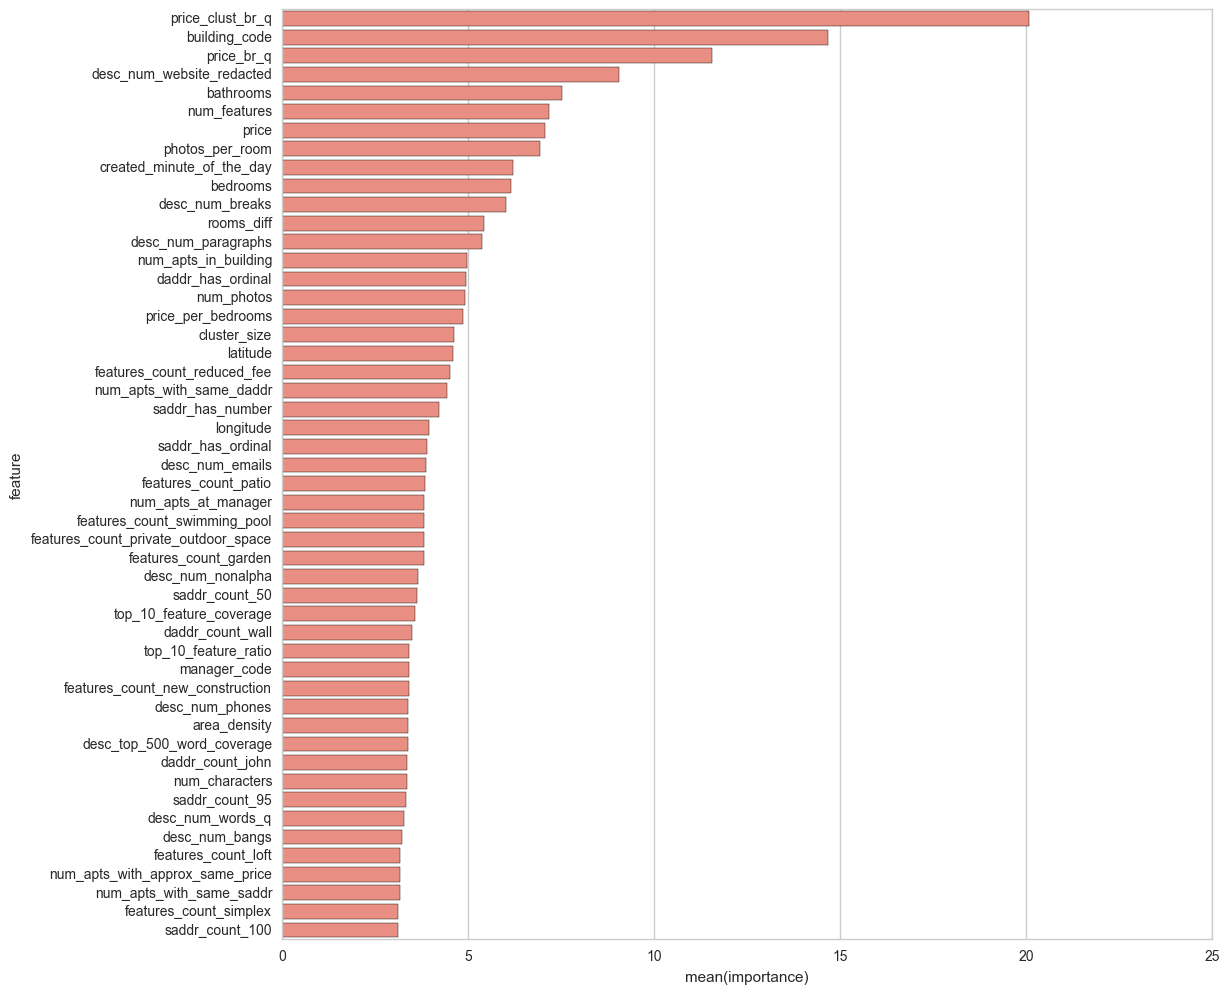

In [23]:
NUM_FEATURES = 50
fscores = m.get_score(importance_type='gain')
fscores = sorted(fscores.items(), key=operator.itemgetter(1))
fscores.reverse()
fscores = fscores[:NUM_FEATURES]
fi = pd.DataFrame({
        'feature': [fs[0] for fs in fscores],
        'importance': [fs[1] for fs in fscores]})
plt.figure(figsize=(12, NUM_FEATURES / 4))
_ = sns.barplot(
        x='importance',
        y='feature',
        data=fi,
        color='salmon')

# Submission

In [24]:
xgtrain = xgb.DMatrix(tr, label=trl)
xgtest = xgb.DMatrix(te)

In [25]:
ps = {}
ps['max_depth'] = 7
ps['eta'] = 0.25
ps['min_child_weight'] = 3
ps['subsample'] = 1.0
ps['colsample_bytree'] = 1.0
ps['colsample_bylevel'] = 1.0
ps['gamma'] = 0.0
ps['lambda'] = 1.0
ps['alpha'] = 0.0
ps['objective'] = 'multi:softprob'
ps['num_class'] = 3
ps['eval_metric'] = 'mlogloss'

In [26]:
model = xgb.train(
            params=ps,
            dtrain=xgtrain,
            num_boost_round=80)
pred_test_y = model.predict(xgtest)

In [27]:
out_df = pd.DataFrame(pred_test_y, index=te.index)
print len(out_df)
out_df.columns = ['low', 'medium', 'high']
out_df.head(10)

74659


,low,medium,high
id,,,
0,0.348172,0.555408,0.096419
1,0.587615,0.204498,0.207887
100,0.760784,0.217636,0.021580
1000,0.532076,0.422564,0.045360
100000,0.662404,0.306207,0.031389
100001,0.985494,0.013514,0.000992
100002,0.722246,0.246131,0.031623
100003,0.568697,0.235791,0.195512
100005,0.617153,0.337038,0.045809


In [28]:
ids = pd.read_json('tmp/raw_data.json')[['listing_id']]
print len(ids)
ids.head()

124011


,listing_id
0,7142618
1,7210040
10,7211212
100,7103890
1000,7143442


In [29]:
s = pd.merge(ids, out_df, left_index=True, right_index=True)
s.head(10)

,listing_id,low,medium,high
0,7142618,0.348172,0.555408,0.096419
1,7210040,0.587615,0.204498,0.207887
100,7103890,0.760784,0.217636,0.021580
1000,7143442,0.532076,0.422564,0.045360
100000,6860601,0.662404,0.306207,0.031389
100001,6840081,0.985494,0.013514,0.000992
100002,6922337,0.722246,0.246131,0.031623
100003,6913616,0.568697,0.235791,0.195512
100005,6937820,0.617153,0.337038,0.045809
100006,6893933,0.583667,0.403323,0.013010


In [30]:
s.to_csv('output/xgb_9.csv', index=False)